# Recursive Feature Elimination using SHAP importance and CV

Backwards Recursive Feature Elimination allows to efficiently reduce the number of features in your dataset, without losing the predictive power of the model. `probatus` implements the following feature elimination routine for **tree-based models**:


    While any features left, iterate:
        1. (Optional) Tune hyperparameters, in case `GridSearchCV` or `RandomSearchCV` are provided as estimators,
        2. Calculate SHAP feature importance using Cross-Validation,
        3. Remove `step` lowest importance features.


The functionality is similar to [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), yet, it removes the lowest importance features based on SHAP features importance. It also supports the use of [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) passed as a `clf`, thanks to which you can perform hyperparameter optimization at each step of the search.
hyperparameters of the model at each round, to tune the model for each features set. Lastly, it supports categorical features (`object` and `category` dtype) and missing values in the data, as long as the model supports them.
 
The main advantages of using this routine are:

- The approach uses a tree-based model to detect the complex relations between features and the target.
- Uses SHAP importance, which is one of the most reliable ways to estimate features importance. Unlike many other techniques, it works with missing values and categorical variables.
- Allows to us [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) in order to optimize hyperparameters at each iteration. This way you can assess if the removal of a given feature reduces the predictive power, or simply requires additional tuning of the model.

The disadvantages are:
- One needs to manually select how many features to keep at the end of the routine, based on how the performance of the model changes between rounds.
- Removing lowest [SHAP](https://shap.readthedocs.io/en/latest/) importance feature does not always translate to choosing the feature with lowest impact on model's performance. Shap importance illustrates how strongly a given feature affects the output of the model, while disregarding correctness of this prediction.
- Currently, the functionality only supports tree-based binary classifiers, in the future the scope might be extended.

## Setup the dataset

In order to use the functionality, let's set up an example dataset with:
- numerical features
- 1 categorical feature
- 1 static feature
- 1 feature with missing values

In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import RandomizedSearchCV
 
feature_names = ['f1_categorical', 'f2_missing', 'f3_static', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, class_sep=0.05, n_informative=6, n_features=20,
                           random_state=0, n_redundant=10, n_clusters_per_class=1)
X = pd.DataFrame(X, columns=feature_names)
X['f1_categorical'] = X['f1_categorical'].apply(lambda x: str(np.round(x*10)))
X['f2_missing'] = X['f2_missing'].apply(lambda x: x if np.random.rand()<0.8 else np.nan)
X['f3_static'] = 0

In [2]:
X.head()

,f1_categorical,f2_missing,f3_static,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
0,34.0,-3.902230,0,0.037207,-0.211075,2.378358,0.474059,-0.580471,2.523367,1.265063,-0.698129,0.320310,0.373186,1.828942,-3.116881,-0.960251,-0.031511,-1.294803,0.115819,-2.727467
1,-25.0,0.772855,0,0.302824,0.729950,0.815054,1.157228,1.347449,-1.880812,0.222902,2.293246,0.286349,0.063909,0.036967,-1.016085,0.035576,-0.439491,0.823261,2.284586,0.674484
2,-7.0,1.350847,0,1.837895,-0.745689,0.327826,0.755258,1.499059,-1.987181,0.093551,0.734911,0.579087,0.216668,-1.523017,-1.940202,0.763642,-0.764415,1.879374,1.239255,0.767797
3,-53.0,4.559465,0,-1.277930,3.688404,-2.369522,0.927847,-0.155483,-2.434361,0.448693,2.021587,-0.609161,-1.699683,-2.938755,1.995516,-2.558037,-1.103081,3.084860,6.632615,0.754824
4,-10.0,1.505766,0,-0.576209,-0.790525,-0.585126,-0.499129,1.324540,-0.077793,0.352424,-1.728604,0.987153,-0.754924,0.257670,1.381853,1.751669,-1.043428,-0.848575,-3.581535,2.810744


In [3]:
X.dtypes.head()

f1_categorical     object
f2_missing        float64
f3_static           int64
f4                float64
f5                float64
dtype: object

## Set up the model and model tuning

You need to set up the model that you would like to use in the feature elimination. `probatus` requires a **tree-based binary classifier** in order to speed up the computation of SHAP feature importance at each step. 
We recommend using [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html), which by default handles missing values and categorical features.

The example below applies randomized search in order to optimize the hyperparameters of the model at each iteration of the search.

In [4]:
clf = lightgbm.LGBMClassifier(max_depth=5, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 7, 10],
    'num_leaves': [3, 5, 7, 10],
}
search = RandomizedSearchCV(clf, param_grid)


## Apply ShapRFECV

Now let's apply the method.

In [5]:
shap_elimination = ShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y)

Removing static features ['f3_static'].
The following variables contain missing values ['f2_missing']. Make sure to imputemissing or apply a model that handles them automatically.
Changing dtype of ['f1_categorical'] from "object" to "category". Treating it as categorical variable. Make sure that the model handles categorical variables, or encode them first.


Round: 1, Current number of features: 19, Current performance: Train 0.947 +/- 0.005, CV Validation 0.905 +/- 0.024. 
Num of features left: 16. Removed features at the end of the round: ['f6', 'f17', 'f4']
Round: 2, Current number of features: 16, Current performance: Train 0.947 +/- 0.005, CV Validation 0.905 +/- 0.024. 
Num of features left: 13. Removed features at the end of the round: ['f2_missing', 'f7', 'f13']
Round: 3, Current number of features: 13, Current performance: Train 0.964 +/- 0.006, CV Validation 0.913 +/- 0.027. 
Num of features left: 11. Removed features at the end of the round: ['f18', 'f12']
Round: 4, Current number of features: 11, Current performance: Train 0.951 +/- 0.009, CV Validation 0.905 +/- 0.037. 
Num of features left: 9. Removed features at the end of the round: ['f10', 'f11']
Round: 5, Current number of features: 9, Current performance: Train 0.959 +/- 0.008, CV Validation 0.914 +/- 0.031. 
Num of features left: 8. Removed features at the end of the ro

At the end of the process, you can investigate the results for each iteration.

In [6]:
report.head()

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,19,"[f1_categorical, f2_missing, f4, f5, f6, f7, f...","[f6, f17, f4]",0.947,0.005,0.905,0.024
2,16,"[f8, f16, f20, f2_missing, f1_categorical, f11...","[f2_missing, f7, f13]",0.947,0.005,0.905,0.024
3,13,"[f8, f16, f20, f5, f11, f1_categorical, f9, f1...","[f18, f12]",0.964,0.006,0.913,0.027
4,11,"[f8, f16, f20, f9, f15, f14, f1_categorical, f...","[f10, f11]",0.951,0.009,0.905,0.037
5,9,"[f8, f16, f20, f9, f15, f14, f5, f19, f1_categ...",[f20],0.959,0.008,0.914,0.031


Once the process is completed, you can visualize the results. 

Let's investigate the performance plot. In this case, the Validation AUC score has a peak at 9 features.

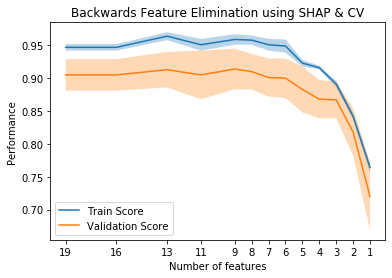

In [7]:
performance_plot = shap_elimination.plot()

Let's see the final feature set:

In [8]:
shap_elimination.get_reduced_features_set(num_features=9)

['f8', 'f16', 'f20', 'f9', 'f15', 'f14', 'f5', 'f19', 'f1_categorical']